# Electricity Consumption Analysis (US 2004–2018)

In [44]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import warnings
import itertools
import statsmodels.api as sm


In [45]:
# Load dataset
df = pd.read_csv("AEP_hourly.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])      # Ubah ke datetime
df.set_index('Datetime', inplace=True)      

# Resample data ke harian
daily_data = df.resample('D').sum()

# Lihat data awal dan akhir
print(daily_data.head())
print(daily_data.tail())
print("Shape:", daily_data.shape)


              AEP_MW
Datetime            
2004-10-01  328544.0
2004-10-02  311997.0
2004-10-03  293450.0
2004-10-04  343417.0
2004-10-05  346553.0
              AEP_MW
Datetime            
2018-07-30  368834.0
2018-07-31  364327.0
2018-08-01  363628.0
2018-08-02  376504.0
2018-08-03   14809.0
Shape: (5055, 1)


## EDA

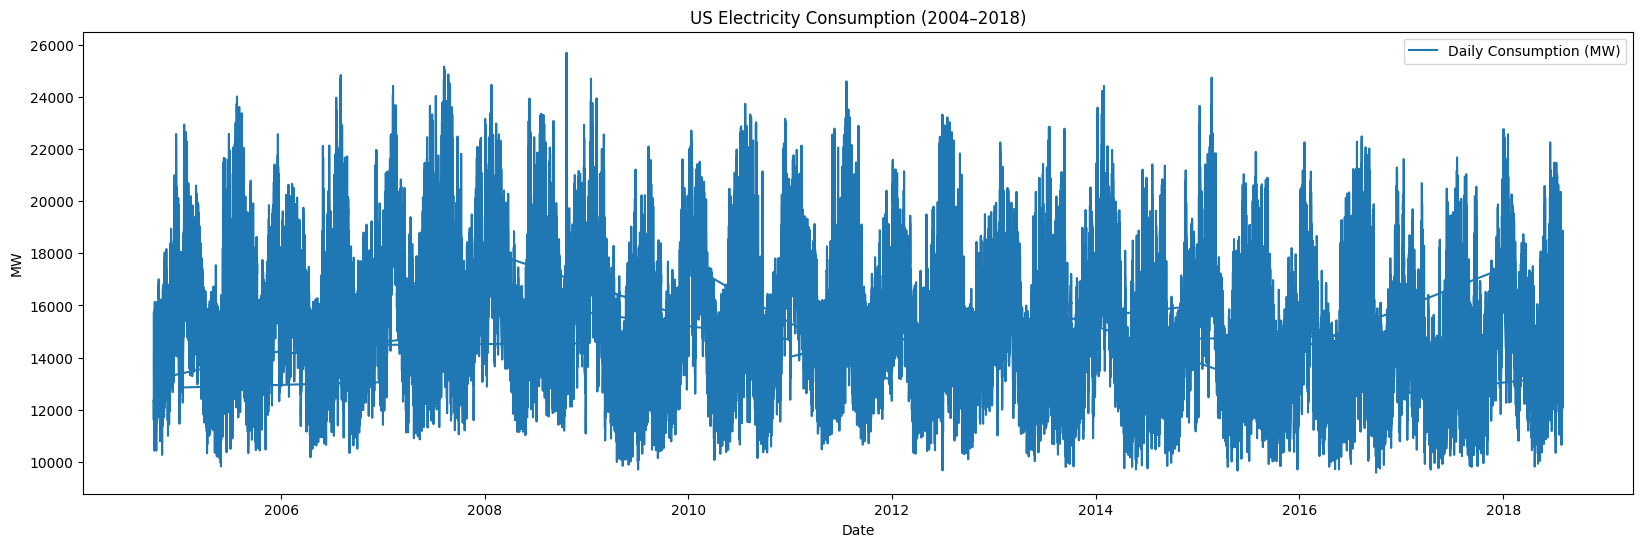

count      5055.000000
mean     371844.218991
std       47605.308633
min       14809.000000
25%      337265.500000
50%      366539.000000
75%      403198.500000
max      548349.000000
Name: AEP_MW, dtype: float64

In [46]:
plt.figure(figsize=(20, 6))
plt.plot(df['AEP_MW'], label="Daily Consumption (MW)")
plt.title("US Electricity Consumption (2004–2018)")
plt.xlabel("Date")
plt.ylabel("MW")
plt.legend()
plt.show()

# Statistik deskriptif
daily_data['AEP_MW'].describe()


In [47]:
# Dapatkan indeks nilai terendah dan tertinggi
min_index = daily_data['AEP_MW'].idxmin()
max_index = daily_data['AEP_MW'].idxmax()

# Gunakan loc untuk mengambil baris berdasarkan indeks
min_value_row = daily_data.loc[min_index]
max_value_row = daily_data.loc[max_index]

# Tampilkan hasil
print("Nilai terendah:")
print(min_value_row)

print("\nNilai tertinggi:")
print(max_value_row)

Nilai terendah:
AEP_MW    14809.0
Name: 2018-08-03 00:00:00, dtype: float64

Nilai tertinggi:
AEP_MW    548349.0
Name: 2009-01-16 00:00:00, dtype: float64


In [48]:
# check missing values
missing_values = daily_data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 AEP_MW    0
dtype: int64


## Time Series Decomposition

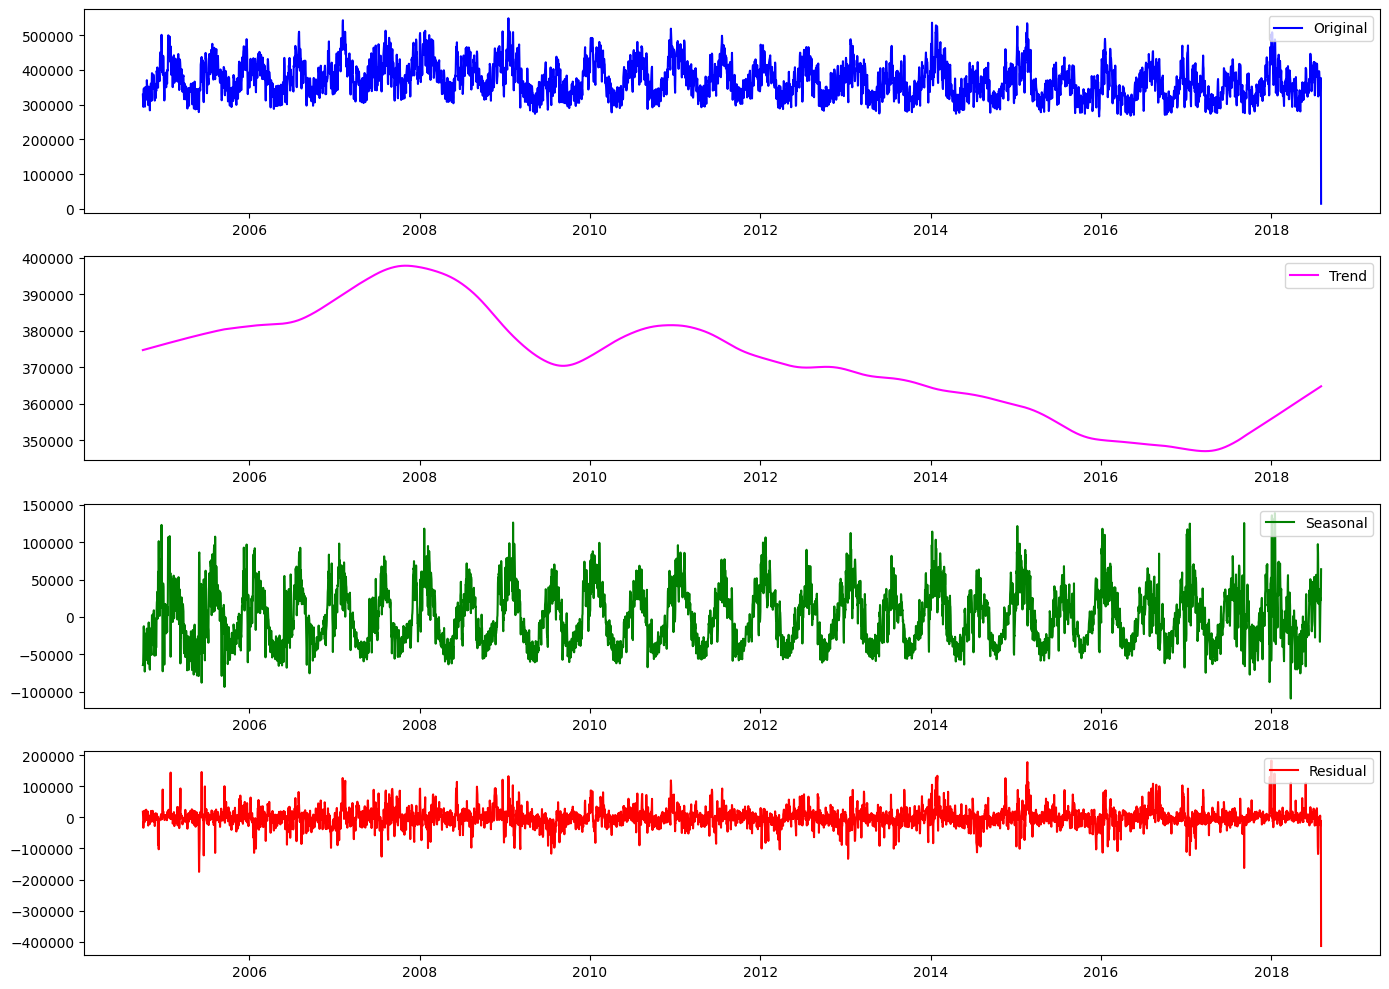

In [49]:
decomposition = seasonal_decompose(daily_data['AEP_MW'], model='additive', period=30)
stl = STL(daily_data['AEP_MW'], period=365, robust=True)
res = stl.fit()

plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(daily_data.index, daily_data['AEP_MW'], label='Original', color='blue')
plt.legend(loc='upper right')

plt.subplot(412)
plt.plot(daily_data.index, res.trend, label='Trend', color='magenta')
plt.legend(loc='upper right')

plt.subplot(413)
plt.plot(daily_data.index, res.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper right')

plt.subplot(414)
plt.plot(daily_data.index, res.resid, label='Residual', color='red')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Uji Stasioneritas

In [50]:
# ADF Test
result = adfuller(daily_data['AEP_MW'].dropna())

print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print('Critical Value ({}): {:.3f}'.format(key, value))

# Interpretasi
if result[1] <= 0.05:
    print("Data stasioner (tolak H0).")
else:
    print("Data tidak stasioner (gagal tolak H0). Perlu differencing.")


ADF Statistic: -7.279596355145723
p-value: 1.5125837189548947e-10
Critical Value (1%): -3.432
Critical Value (5%): -2.862
Critical Value (10%): -2.567
Data stasioner (tolak H0).


## Rolling Mean & Std

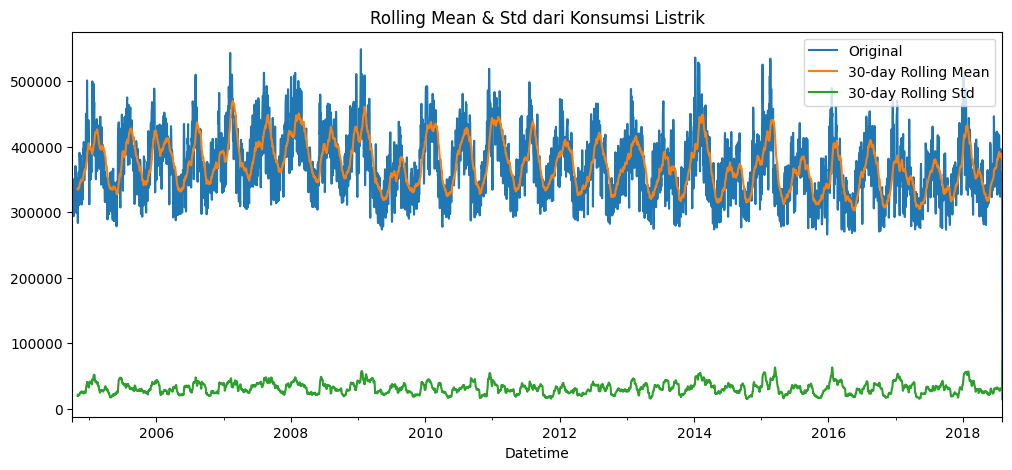

In [51]:
plt.figure(figsize=(12,5))
daily_data['AEP_MW'].plot(label='Original')
daily_data['AEP_MW'].rolling(window=30).mean().plot(label='30-day Rolling Mean')
daily_data['AEP_MW'].rolling(window=30).std().plot(label='30-day Rolling Std')
plt.legend()
plt.title("Rolling Mean & Std dari Konsumsi Listrik")
plt.show()


## Train - Test Data

In [52]:
train = daily_data.loc[:'2016-12-31']['AEP_MW']
test  = daily_data.loc['2017-01-01':]['AEP_MW']

print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 4475, Test size: 580


## Holt-Winters Seasonal Model

In [53]:
# Model Holt-Winters dengan musiman
model = ExponentialSmoothing(
    train, 
    seasonal='mul',  
    trend='add',     
    seasonal_periods=365
)
fit = model.fit()

c:\pythonapp\myvenv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [54]:
# Forecast sebanyak panjang test
forecast = fit.forecast(len(test))
forecast = forecast.clip(lower=0) # Pastikan tidak ada nilai negatif
forecast_mean = forecast

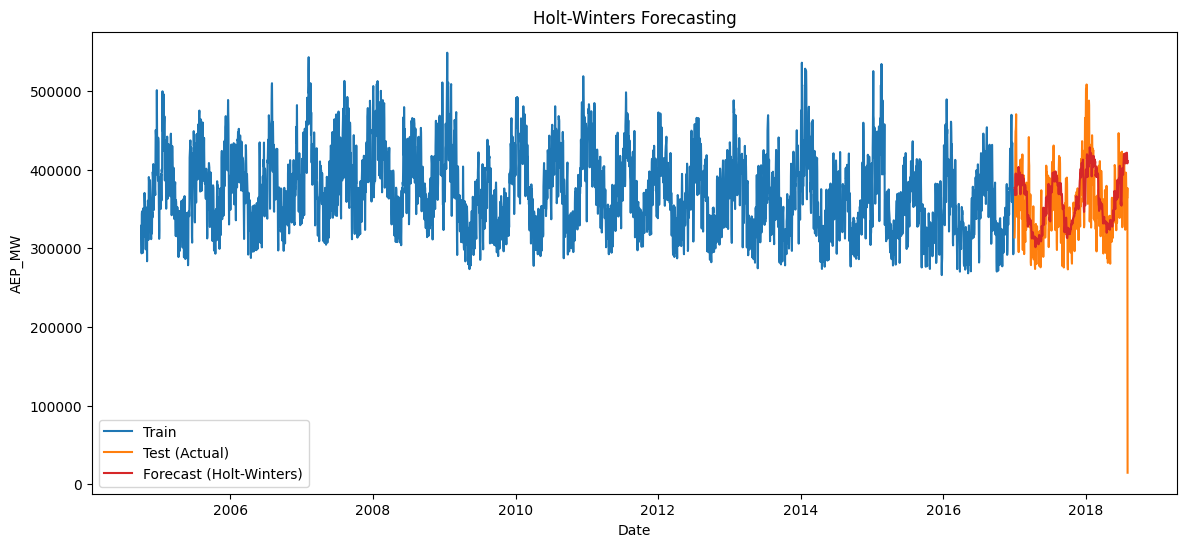

In [55]:
# Plot hasil
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Train', color='tab:blue')
plt.plot(test.index, test, label='Test (Actual)', color='tab:orange')
plt.plot(test.index, forecast_mean, label='Forecast (Holt-Winters)', color='tab:red')
plt.title('Holt-Winters Forecasting')
plt.xlabel('Date')
plt.ylabel('AEP_MW')
plt.legend()
plt.show()

In [56]:
# Evaluasi akurasi
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
avg_aep = train.mean()
rmse_percentage = (rmse / avg_aep) * 100
print("RMSE(%) on Test Set:", rmse_percentage)

mape = np.mean(np.abs((test - forecast) / test)) * 100
print("MAPE(%) on Test Set:", mape)



RMSE(%) on Test Set: 11.120621648197398
MAPE(%) on Test Set: 13.052614679236093


## Pola Bulanan

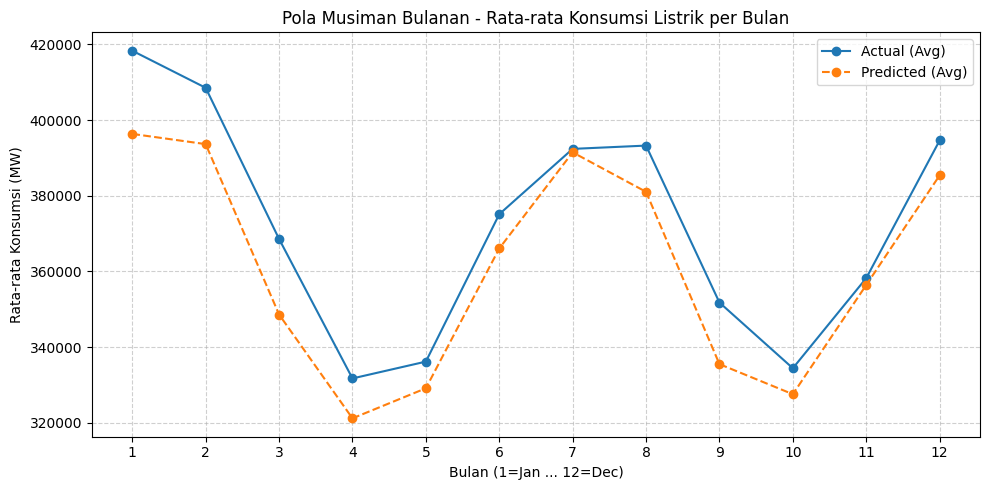

In [57]:
daily_data['forecast'] = np.nan   # bikin kolom kosong dulu
daily_data.loc[test.index, 'forecast'] = forecast.values

# Tambahkan kolom bulan
daily_data['Month'] = daily_data.index.month

# Hitung rata-rata per bulan (Actual & Predicted)
monthly_avg = daily_data.groupby('Month')[['AEP_MW','forecast']].mean()

plt.figure(figsize=(10, 5))
plt.plot(monthly_avg.index, monthly_avg['AEP_MW'], 
         label='Actual (Avg)', marker='o')
plt.plot(monthly_avg.index, monthly_avg['forecast'], 
         label='Predicted (Avg)', marker='o', linestyle='--')
plt.title("Pola Musiman Bulanan - Rata-rata Konsumsi Listrik per Bulan")
plt.xlabel("Bulan (1=Jan ... 12=Dec)")
plt.ylabel("Rata-rata Konsumsi (MW)")
plt.xticks(range(1, 13))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



## Pola Mingguan

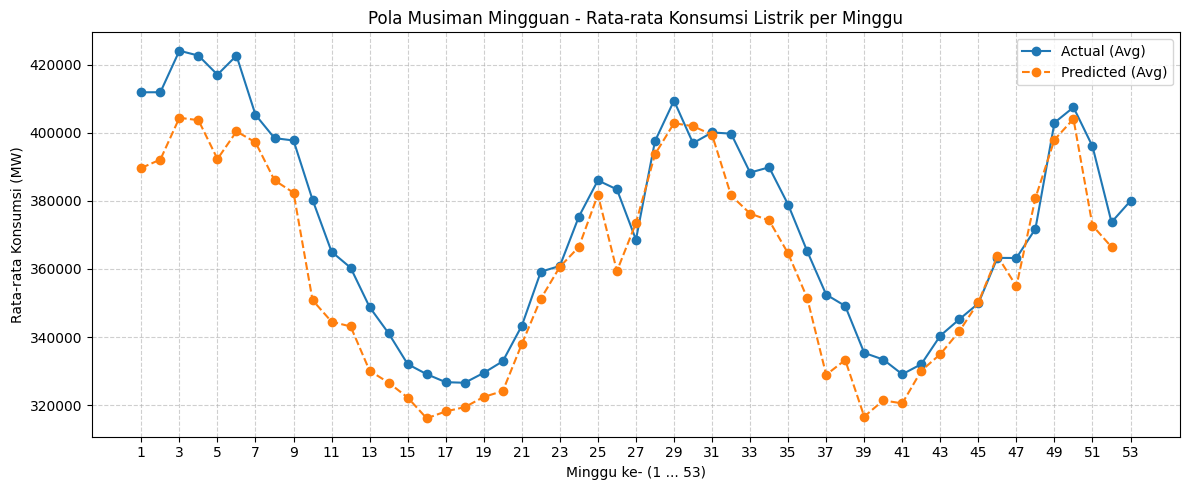

In [58]:
# Tambahkan kolom minggu
daily_data['Week'] = daily_data.index.isocalendar().week

# Buat kolom forecast dulu kalau belum ada
if 'forecast' not in daily_data.columns:
    daily_data['forecast'] = np.nan
    daily_data.loc[test.index, 'forecast'] = forecast.values

# Hitung rata-rata per minggu (Actual & Forecast)
weekly_avg = daily_data.groupby('Week')[['AEP_MW','forecast']].mean()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(weekly_avg.index, weekly_avg['AEP_MW'], 
         label='Actual (Avg)', marker='o')
plt.plot(weekly_avg.index, weekly_avg['forecast'], 
         label='Predicted (Avg)', marker='o', linestyle='--')
plt.title("Pola Musiman Mingguan - Rata-rata Konsumsi Listrik per Minggu")
plt.xlabel("Minggu ke- (1 ... 53)")
plt.ylabel("Rata-rata Konsumsi (MW)")
plt.xticks(range(1, 54, 2))  
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


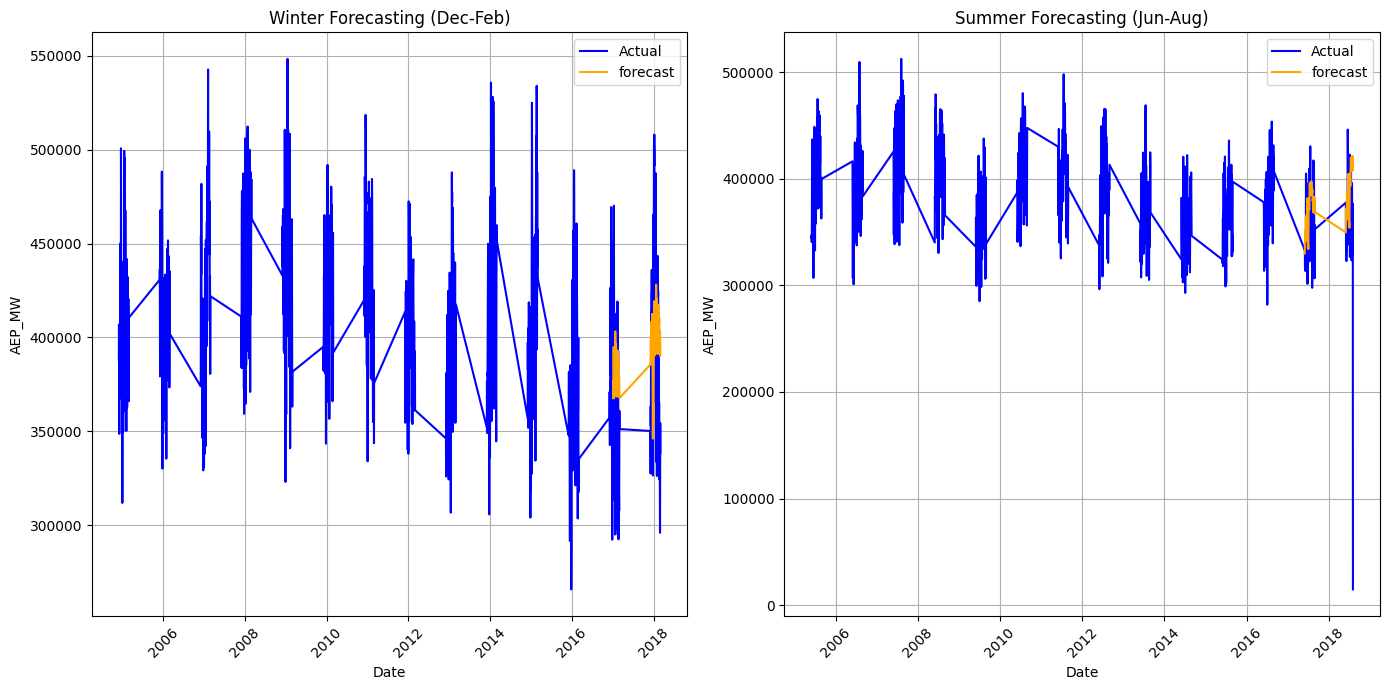

In [67]:
# Pisahkan data untuk musim dingin dan musim panas
winter_data = daily_data[daily_data['Month'].isin([12, 1, 2])]
summer_data = daily_data[daily_data['Month'].isin([6, 7, 8])]

# Visualisasi
plt.figure(figsize=(14, 7))

# Musim Dingin
plt.subplot(1, 2, 1)
plt.plot(winter_data.index, winter_data['AEP_MW'], label='Actual', color='blue')
plt.plot(winter_data.index, winter_data['forecast'], label='forecast', color='orange')
plt.title('Winter Forecasting (Dec-Feb)')
plt.xlabel('Date')
plt.ylabel('AEP_MW')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Musim Panas
plt.subplot(1, 2, 2)
plt.plot(summer_data.index, summer_data['AEP_MW'], label='Actual', color='blue')
plt.plot(summer_data.index, summer_data['forecast'], label='forecast', color='orange')
plt.title('Summer Forecasting (Jun-Aug)')
plt.xlabel('Date')
plt.ylabel('AEP_MW')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Analisis Tambahan

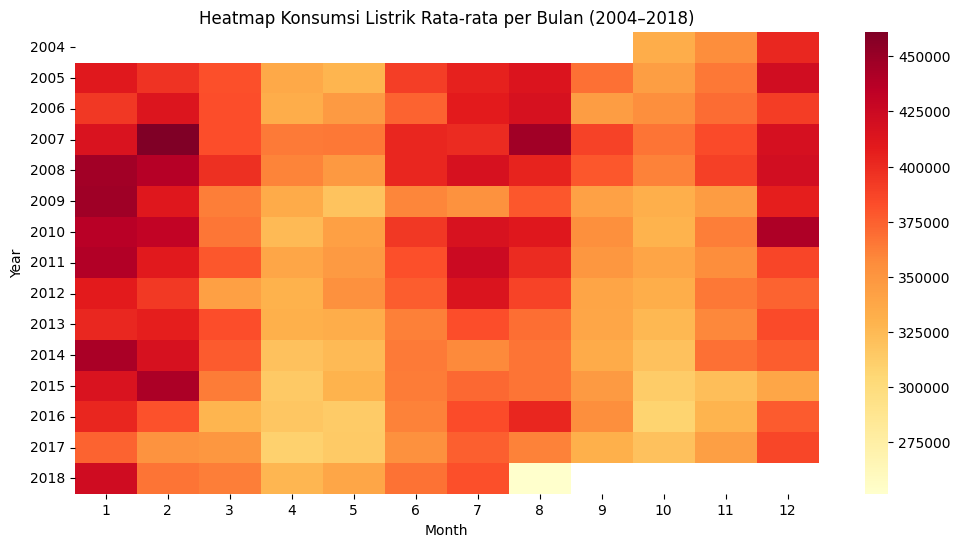

In [59]:
# Tambahkan kolom bulan & tahun
daily_data['year'] = daily_data.index.year
daily_data['month'] = daily_data.index.month

# Hitung rata-rata konsumsi per bulan-tahun
monthly_avg = daily_data.groupby(['year','month'])['AEP_MW'].mean().unstack()

plt.figure(figsize=(12,6))
sns.heatmap(monthly_avg, cmap="YlOrRd", annot=False)
plt.title("Heatmap Konsumsi Listrik Rata-rata per Bulan (2004–2018)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()


Notes :
- Winter : December - February
- Spring : March - May
- Summer : June - August
- Autumn : September - November

## Winter Trend

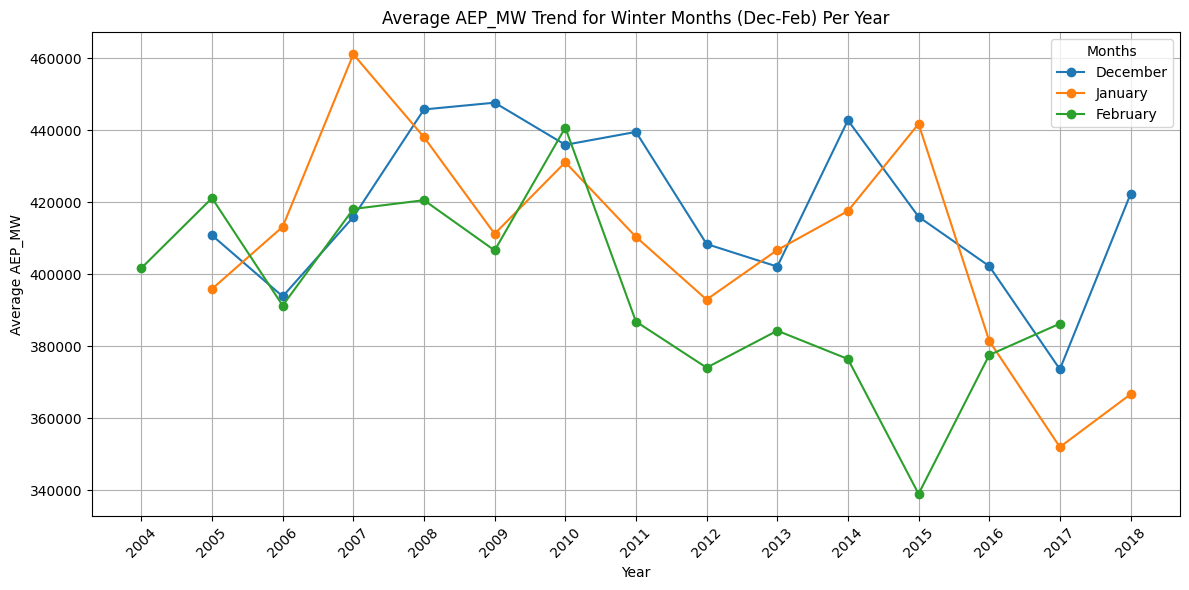

In [60]:
# Filter untuk bulan Desember (12), Januari (1), dan Februari (2) == Winter Months
winter_data = daily_data[daily_data['month'].isin([12, 1, 2])]

# Kelompokkan data berdasarkan tahun dan bulan, lalu hitung rata-rata AEP_MW
monthly_trend = winter_data.groupby(['year', 'month'])['AEP_MW'].mean().unstack()

# Visualisasikan tren
plt.figure(figsize=(12, 6))
for col in monthly_trend.columns:
    plt.plot(monthly_trend.index, monthly_trend[col], marker='o', label=f'Month {col}')

plt.title('Average AEP_MW Trend for Winter Months (Dec-Feb) Per Year')
plt.xlabel('Year')
plt.ylabel('Average AEP_MW')
plt.xticks(monthly_trend.index, rotation=45)
plt.legend(title='Months', labels=['December', 'January', 'February'])
plt.grid()
plt.tight_layout()
plt.show()

## Summer Trend

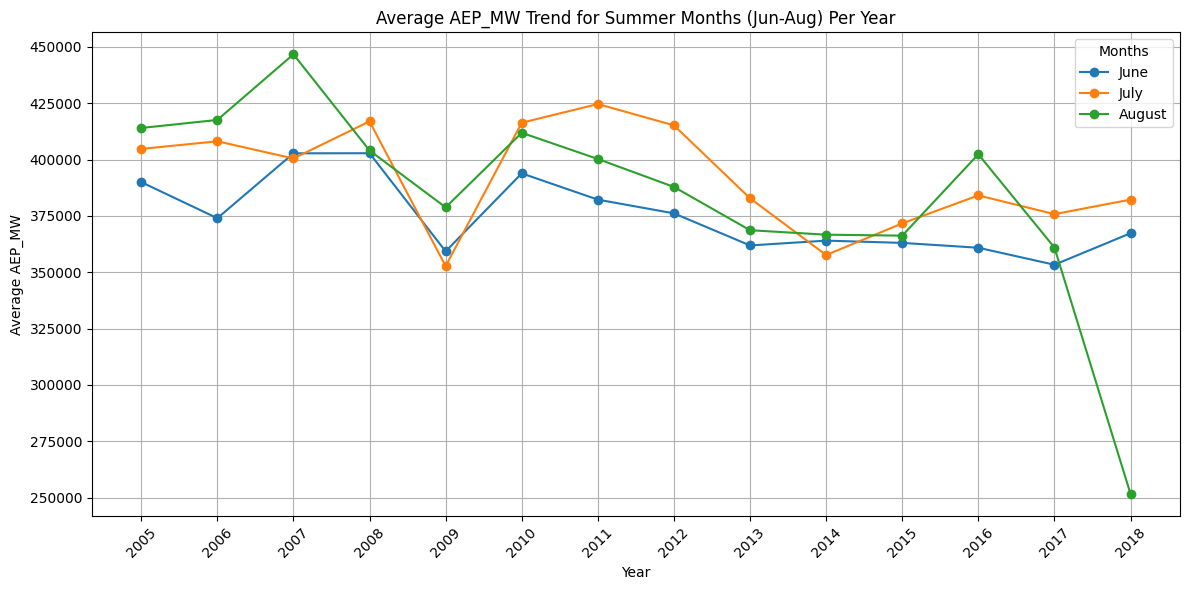

In [61]:
# Filter untuk bulan Juni (6), Juli (7), dan Agustus (8) == Summer Months
summer_data = daily_data[daily_data['month'].isin([6, 7, 8])]

# Kelompokkan data berdasarkan tahun dan bulan, lalu hitung rata-rata AEP_MW
monthly_trend = summer_data.groupby(['year', 'month'])['AEP_MW'].mean().unstack()

# Visualisasikan tren
plt.figure(figsize=(12, 6))
for col in monthly_trend.columns:
    plt.plot(monthly_trend.index, monthly_trend[col], marker='o', label=f'Month {col}')

plt.title('Average AEP_MW Trend for Summer Months (Jun-Aug) Per Year')
plt.xlabel('Year')
plt.ylabel('Average AEP_MW')
plt.xticks(monthly_trend.index, rotation=45)
plt.legend(title='Months', labels=['June', 'July', 'August'])
plt.grid()
plt.tight_layout()
plt.show()

In [63]:
daily_data['days']

Datetime
2004-10-01       Friday
2004-10-02     Saturday
2004-10-03       Sunday
2004-10-04       Monday
2004-10-05      Tuesday
                ...    
2018-07-30       Monday
2018-07-31      Tuesday
2018-08-01    Wednesday
2018-08-02     Thursday
2018-08-03       Friday
Freq: D, Name: days, Length: 5055, dtype: object

C:\Users\72532\AppData\Local\Temp\ipykernel_32188\4071303289.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=days_avg.index, y=days_avg.values, palette="coolwarm")


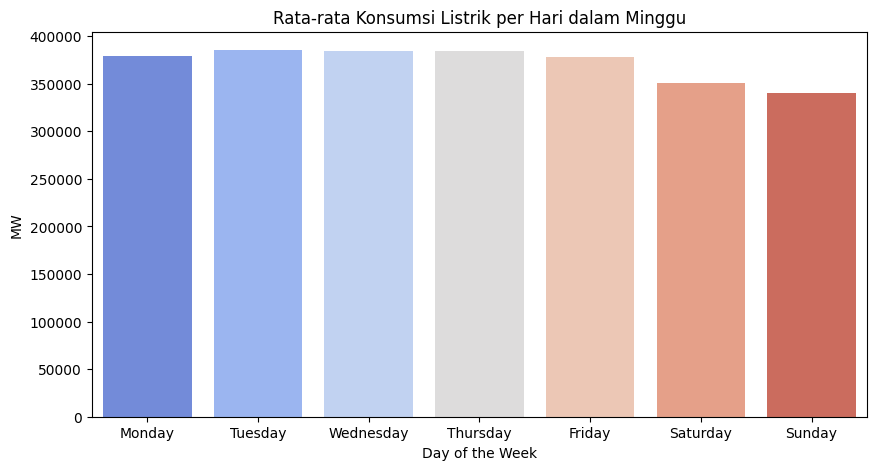

In [62]:
# Tambahkan kolom days
daily_data['days'] = daily_data.index.day_name()

# Urutkan agar mulai dari Senin
days_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Hitung rata-rata konsumsi per hari dalam seminggu
days_avg = daily_data.groupby('days')['AEP_MW'].mean().reindex(days_order)

plt.figure(figsize=(10,5))
sns.barplot(x=days_avg.index, y=days_avg.values, palette="coolwarm")
plt.title("Rata-rata Konsumsi Listrik per Hari dalam Minggu")
plt.xlabel("Day of the Week")
plt.ylabel("MW")
plt.show()


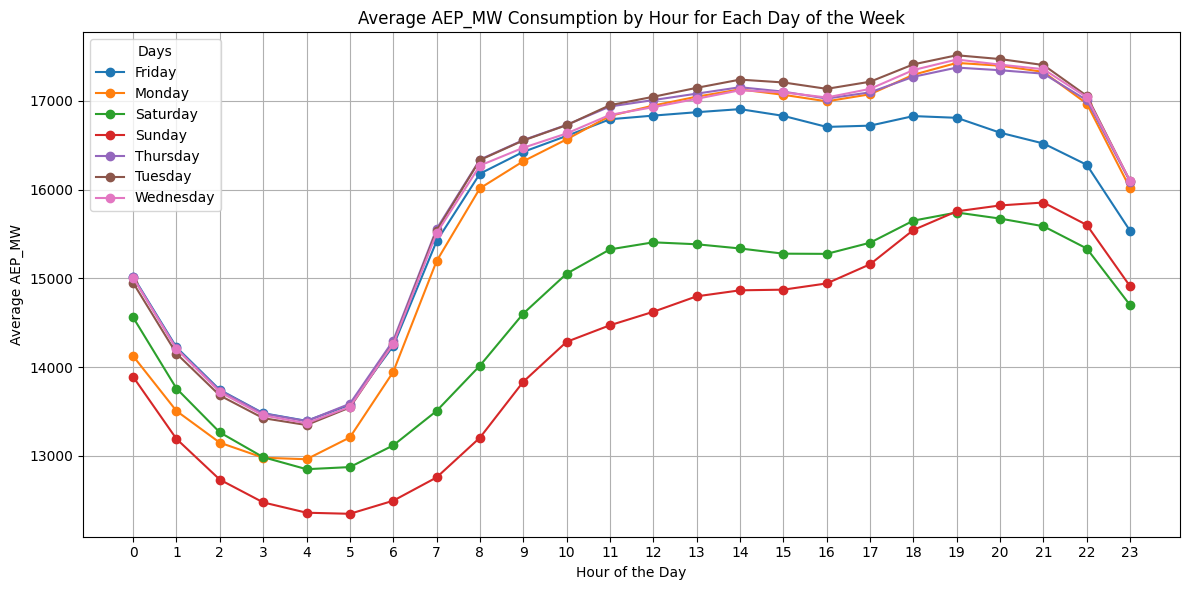

In [65]:
# Tambahkan kolom hari dan jam
df['Day'] = df.index.day_name()
df['Hour'] = df.index.hour

# Hitung rata-rata konsumsi per jam untuk setiap hari
hourly_avg_per_day = df.groupby(['Day', 'Hour'])['AEP_MW'].mean().unstack()

# Visualisasikan hasil
plt.figure(figsize=(12, 6))
for day in hourly_avg_per_day.index:
    plt.plot(hourly_avg_per_day.columns, hourly_avg_per_day.loc[day], marker='o', label=day)

plt.title('Average AEP_MW Consumption by Hour for Each Day of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Average AEP_MW')
plt.xticks(hourly_avg_per_day.columns)  # Menampilkan setiap jam di sumbu x
plt.legend(title='Days')
plt.grid()
plt.tight_layout()
plt.show()